# Importing the necessary libraries

In [ ]:
import os
import tqdm
import pywt
import zipfile
import librosa
import warnings
import numpy as np
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from scipy.signal import hilbert, filtfilt, butter, lfilter
from keras.models import Sequential
from keras.callbacks import Callback
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization

%matplotlib inline
warnings.filterwarnings('ignore')

# Downloading the dataset

In [ ]:
!wget https://physionet.org/static/published-projects/challenge-2016/classification-of-heart-sound-recordings-the-physionetcomputing-in-cardiology-challenge-2016-1.0.0.zip

In [ ]:
!unzip heart_data.zip -d data

# Preprocessing
- Homomorphic Envelopes & Butter Filters
- Dataset sampling
- Data visualization using
  *   MFCC (Mel Frequency Cepstral Coefficients)
  *   TSNE (t-distributed stochastic neighbor embedding)



In [ ]:
def heart_rate(y, fs):
    def homomorphic_envelope(y, fs, f_LPF=8, order=3):
        b, a = butter(order, 2 * f_LPF / fs, 'low')
        he = np.exp(filtfilt(b, a, np.log(np.abs(hilbert(y)))))
        return he
  
    he = homomorphic_envelope(y, fs)
    x = he - np.mean(he);
  
    corr = np.correlate(x, x, mode='full')
    corr = corr[int(corr.size/2):]

    min_index = int(0.5*fs)
    max_index = int(2*fs)

    index = np.argmax(corr[min_index:max_index])
    true_index = index+min_index

    heartRate = 60/(true_index/fs)
    
    return heartRate

y, fs = librosa.load('data/data/training-a/a0001.wav', sr=None)
heart_rate(y, fs)

61.03763987792472

In [ ]:
## Display a normal heart sound and an abnormal heart sound

def load_heart_sound(path, title):
    """ Load and display normal/abnormal sound files """
    normal_x, normal_fs = librosa.load(path)
    normal_x = normal_x[:5*normal_fs]
    librosa.display.waveshow(normal_x, sr=normal_fs)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    IPython.display.display(IPython.display.Audio(normal_x, rate=normal_fs))
    return "Done"

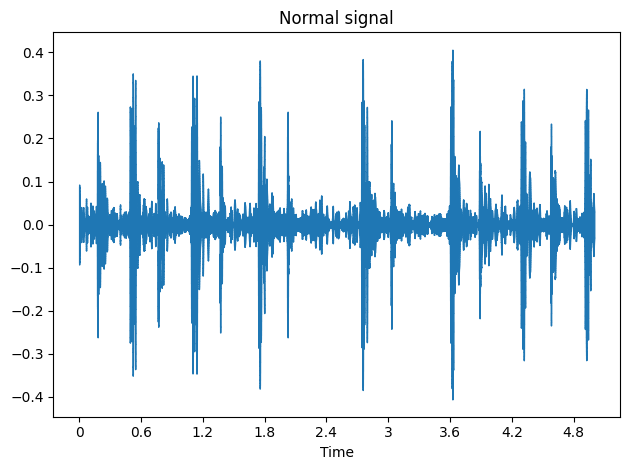

'Done'

In [ ]:
load_heart_sound('data/data/training-a/a0007.wav', 'Normal signal')

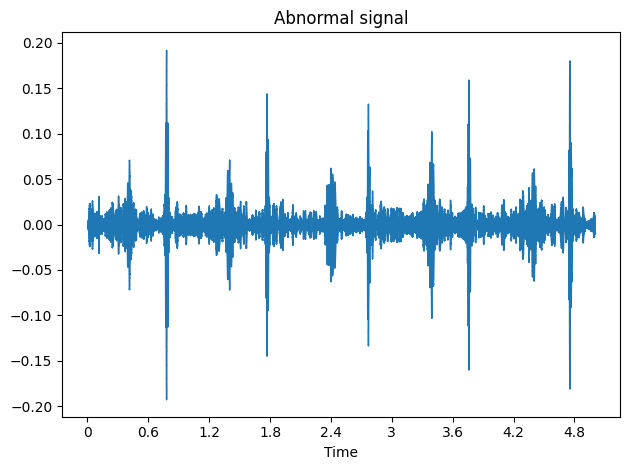

'Done'

In [ ]:
load_heart_sound('data/data/training-a/a0001.wav', 'Abnormal signal')

In [ ]:
# Visualize MFCCs of a normal and an abnormal audio
def get_mfcc(path, title1, title2):
    """ Get MFCCs of a normal signal and display """
    x, fs = librosa.load(path)
    mfccs = librosa.feature.mfcc(y=x, sr=fs)
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
    fig.tight_layout(pad=5.0)
    scaled_mfccs = scale(mfccs, axis=1)
    img1 = librosa.display.specshow(mfccs, sr=fs, x_axis='time', ax=ax[0])
    fig.colorbar(img1, ax=ax[0])
    ax[0].set(title=title1)
    img2 = librosa.display.specshow(scaled_mfccs, sr=fs, x_axis='time')
    fig.colorbar(img2, ax=ax[1])
    ax[1].set(title=title2)
    return

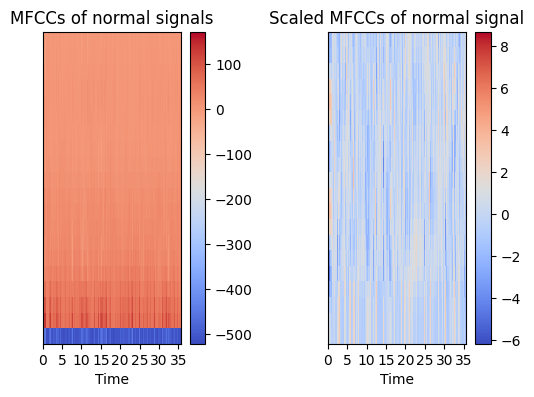

In [ ]:
get_mfcc('data/data/training-a/a0007.wav', 'MFCCs of normal signals', 'Scaled MFCCs of normal signal')

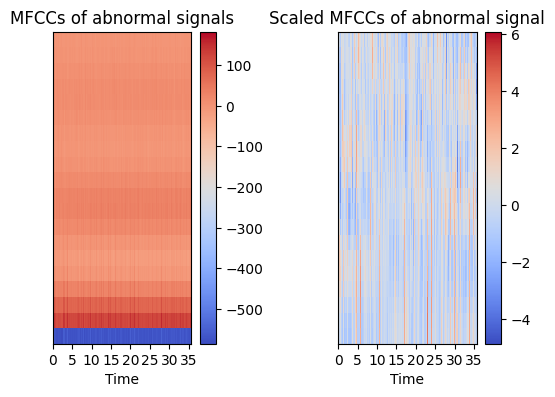

In [ ]:
get_mfcc('data/data/training-a/a0001.wav', 'MFCCs of abnormal signals', 'Scaled MFCCs of abnormal signal')

In [ ]:
def extract_feature(file,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
    # nMFCC, flatten, mean only apply when feat='mfcc'
    
    def butter_bandpass_filter(data, fs, lowcut=25, highcut=400, order=5):
        nyq = 0.5*fs
        low = lowcut/nyq
        high = highcut/nyq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y

    # Load data and pre-process
    data, rate = librosa.load(file, sr=None)
    data = data[:5*rate]
    
    if flt:
        data = butter_bandpass_filter(data, rate)
    
    if feat == 'mfcc':
        if flatten:
            return librosa.feature.mfcc(y=data,sr=rate,n_mfcc=nMFCC).flatten()
        else:
            data = librosa.resample(y=data, orig_sr=rate, target_sr=22050)
            mfcc = librosa.feature.mfcc(y=data, n_mfcc=nMFCC)
            if mean:
                return np.mean(mfcc.T,axis=0)
            else:
                return mfcc
            
    elif feat == 'spamp':
        return abs(np.fft.rfft(data))
    
    elif feat == 'wavelet':
        cA, cD = pywt.dwt(data, 'db1')
        return cD
    
    elif feat == 'mfcc-dwt':
        data = librosa.resample(data, rate, 22050)
        mfcc = np.mean((librosa.feature.mfcc(y=data, n_mfcc=nMFCC)).T,axis=0)
        cA, cD = pywt.dwt(data, 'db1')
        return np.concatenate((mfcc, cD))
    
    elif feat == 'raw':
        return data
    
    else:
        raise ValueError('Invalid second argument')

In [ ]:
def read_dataset(dataset,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
    def read_dir(dir_path,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False):
        # Read REFERENCE.csv
        if dir_path[-1] == '/':
            dir_path = dir_path[:-1]
        csv_path = dir_path + '/REFERENCE.csv'
        df = pd.read_csv(csv_path, header=None)
        features = []
        labels = []
        N = df.shape[0]

        for i in range(N):
            wav_path = dir_path +'/' + df.iat[i,0] + '.wav'
            features.append(extract_feature(wav_path,feat,flt,nMFCC,flatten,mean))
            if df.iat[i,1] == 1:
                labels.append(1) # abnormal
            else:
                labels.append(0) # normal

        return features, labels
    
    if dataset[-1] == '/':
        dataset = dataset[:-1]
       
    # Read dataset
    data_a, labels_a = read_dir(dataset+'/training-a',feat,flt,nMFCC,flatten,mean)
    data_b, labels_b = read_dir(dataset+'/training-b',feat,flt,nMFCC,flatten,mean)
    data_c, labels_c = read_dir(dataset+'/training-c',feat,flt,nMFCC,flatten,mean)
    data_d, labels_d = read_dir(dataset+'/training-d',feat,flt,nMFCC,flatten,mean)
    data_e, labels_e = read_dir(dataset+'/training-e',feat,flt,nMFCC,flatten,mean)
    data_f, labels_f = read_dir(dataset+'/training-f',feat,flt,nMFCC,flatten,mean)
    
    data = np.concatenate((data_a, data_b, data_c, data_d, \
                            data_e, data_f))
    labels = np.concatenate((labels_a, labels_b, labels_c, labels_d, \
                             labels_e, labels_f))
    
    return data, labels

In [ ]:
one_wav_path = 'data/data/training-a/a0001.wav'
features = extract_feature(one_wav_path,feat='mfcc',flt=True,nMFCC=96,flatten=True,mean=False)
features

array([-542.44162905, -520.31596561, -508.35510986, ...,   -0.9530565 ,
         -0.94693011,   -1.90733174])

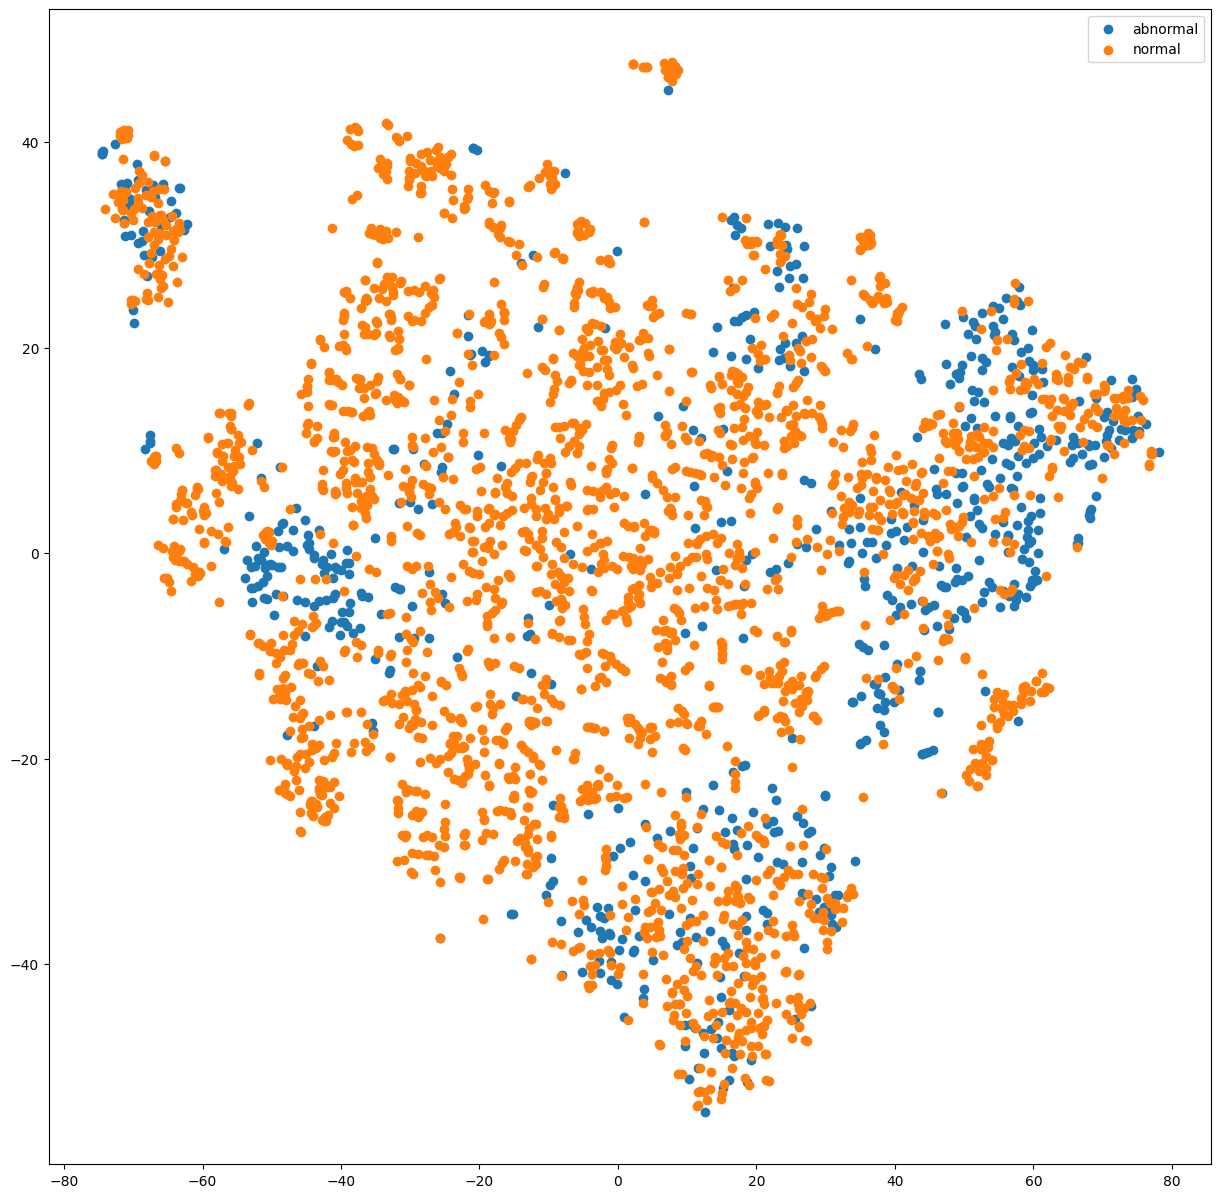

In [ ]:
"""t-distributed stochastic neighbor embedding (TSNE)"""
mfcc, label = read_dataset('data/data/')

# compile model
tsne_model = TSNE().fit_transform(mfcc)

# visualize model
plt.figure(figsize = (15,15))
plt.scatter(tsne_model[label==1,0], tsne_model[label==1,1])
plt.scatter(tsne_model[label==0,0], tsne_model[label==0,1])
plt.legend(['abnormal', 'normal'])
plt.show()

In [ ]:
def prepare_2D(X, Y):
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    Y = to_categorical(Y)
    # split training and validation sets
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3)
    xtest, xvalid, ytest, yvalid = train_test_split(xtest, ytest, test_size=0.5)
    
    return xtrain, xvalid, xtest, ytrain, yvalid, ytest
    
## 2D CNN - 40 mean MFCCs
mfcc402, label = read_dataset('data/data/',flt=False,nMFCC=40,flatten=False)
xtrain402,xvalid402,xtest402,ytrain402,yvalid402,ytest402 = prepare_2D(mfcc402,label)

In [ ]:
class Metrics(Callback):
    def __init__(self, validation_data=()):
        super(Metrics, self).__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        self.validation_data = (xvalid402, yvalid402)
        val_predict = np.asarray(self.model.predict(self.validation_data[0])).round()
        val_predict = np.argmax(val_predict, axis=1)
        val_targ = np.argmax(self.validation_data[1], axis=1)
        _val_precision, _val_recall, _val_f1, _ = \
        precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

In [ ]:
def plot_history(history, name='CNN'):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(name+' loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation fscore values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(name+' Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    fig.savefig(name+'-history.png')
    return

In [ ]:
def plot_metrics(metrics,name='CNN'):
    fig, axs = plt.subplots(1, 3, figsize=(25,5))
    
    # Plot validation fscore values
    axs[0].plot(metrics.val_f1s)
    axs[0].set_title(name+' Validation Fscore')
    axs[0].set_ylabel('Fscore')
    axs[0].set_xlabel('Epoch')
    
    # Plot validation recall values
    axs[1].plot(metrics.val_recalls)
    axs[1].set_title(name+' Validation Recall')
    axs[1].set_ylabel('Recall')
    axs[1].set_xlabel('Epoch')
    
    # Plot validation precision values
    axs[2].plot(metrics.val_precisions)
    axs[2].set_title(name+' Validation Precision')
    axs[2].set_ylabel('Precision')
    axs[2].set_xlabel('Epoch')
    
    fig.savefig(name+'-metrics.png')
    return

# Initial attempts at constructing a model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 215, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 107, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 106, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 53, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 52, 64)         8256      
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 51, 128)        3

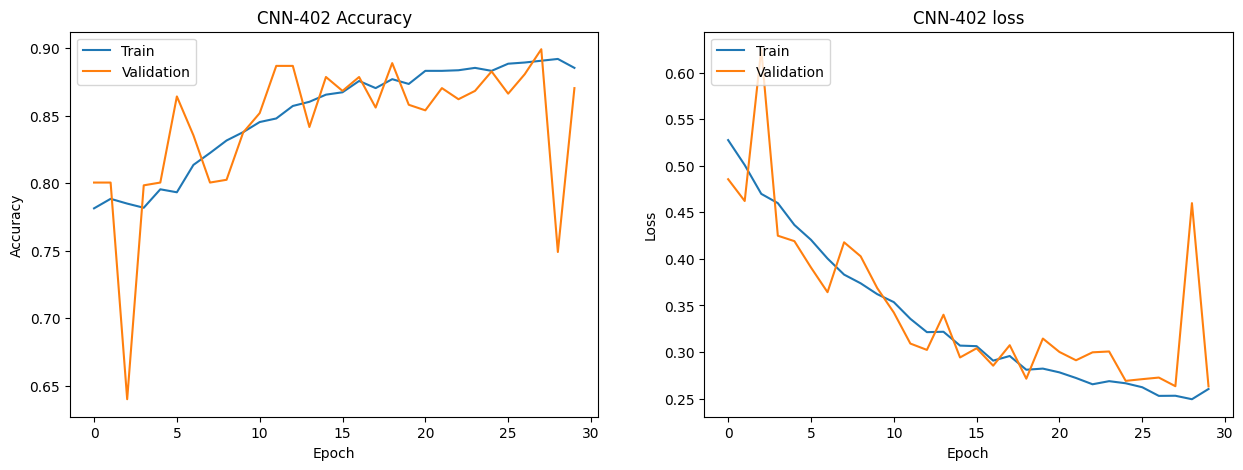

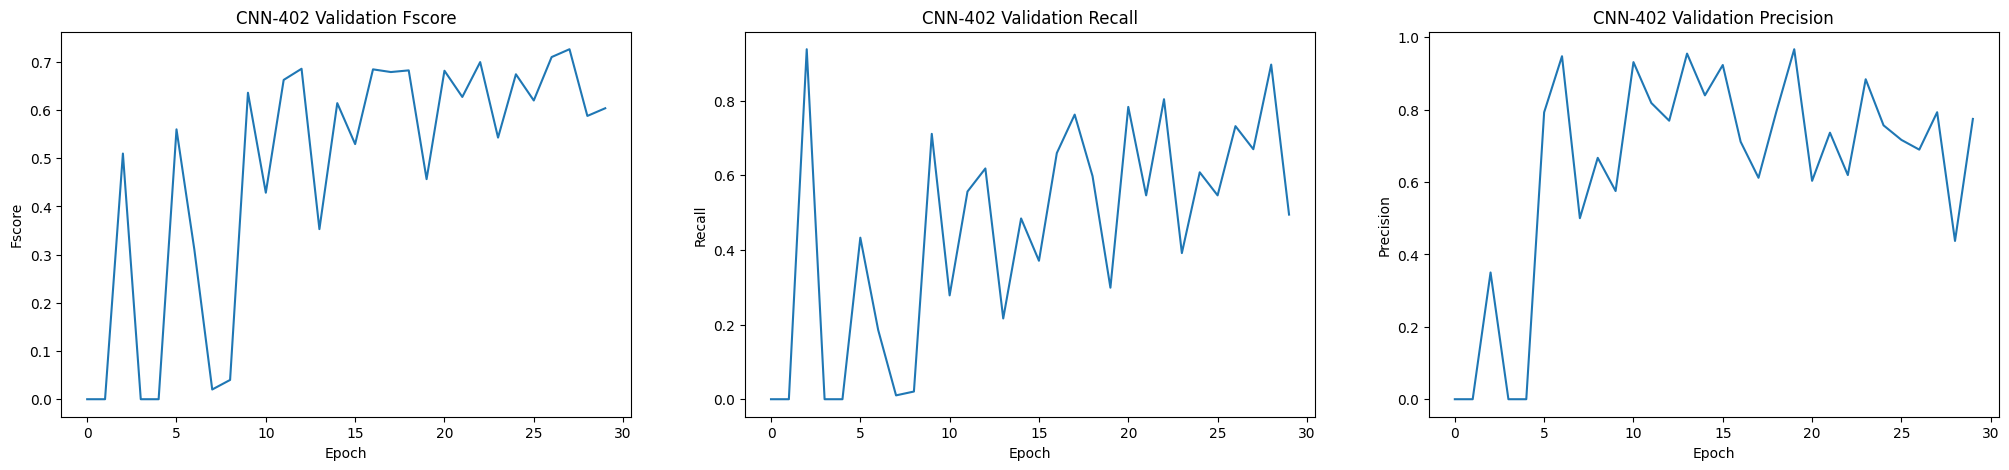

In [ ]:
# AlexNet
model402 = Sequential([
    Conv2D(16, kernel_size=2, activation='relu', input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=2, activation='relu'),
    Conv2D(128, kernel_size=2, activation='relu'),
    Conv2D(256, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

# compile
model402.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
model402.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = model402.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(model402.predict(xtest402),axis=1)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 39, 215, 16)       80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 107, 16)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 106, 32)       2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 53, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 52, 64)         8256      
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 51, 128)       

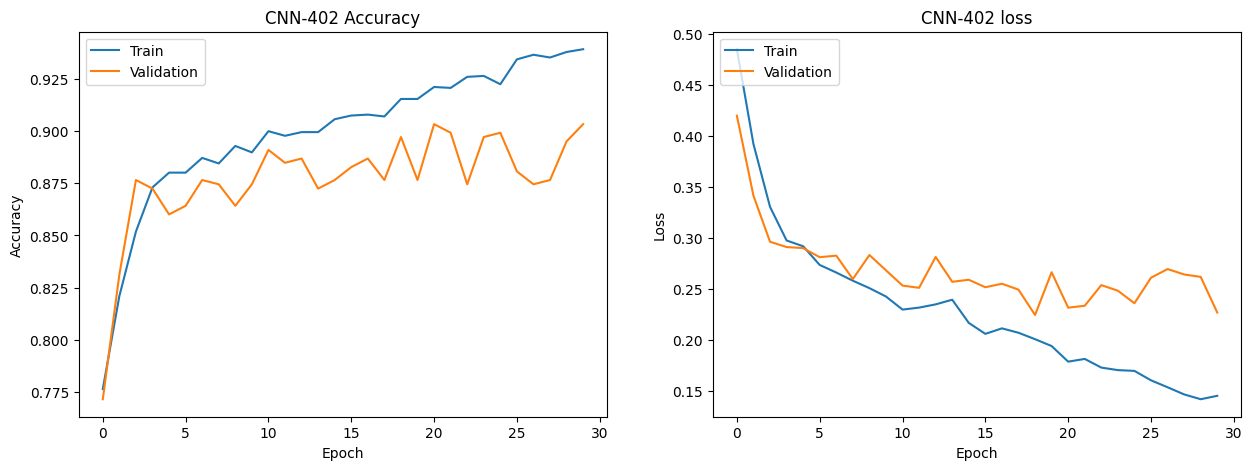

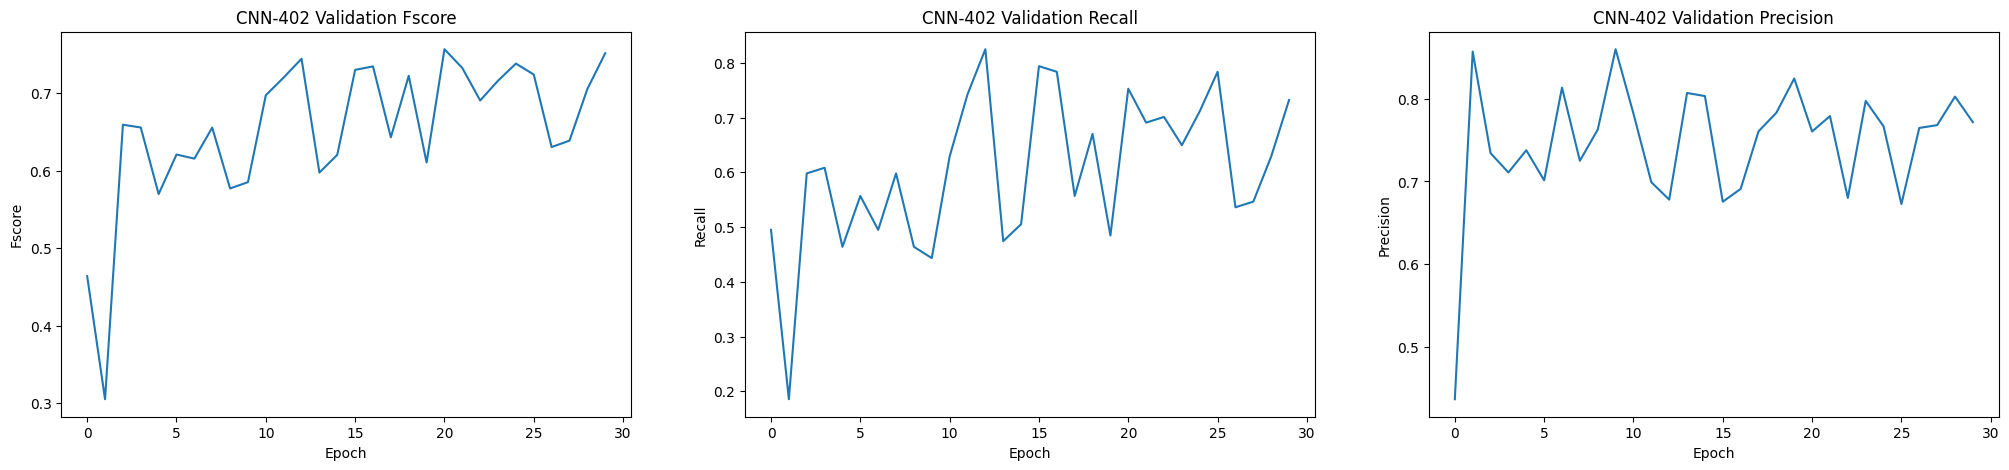

In [ ]:
# AlexNet
model402 = Sequential([
    Conv2D(16, kernel_size=2, activation='relu', input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=2, activation='relu'),
    Conv2D(128, kernel_size=2, activation='relu'),
    Conv2D(256, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

# compile
model402.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model402.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = model402.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(model402.predict(xtest402),axis=1)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 39, 215, 16)       80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 19, 107, 16)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 18, 106, 32)       2080      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 53, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 53, 32)        

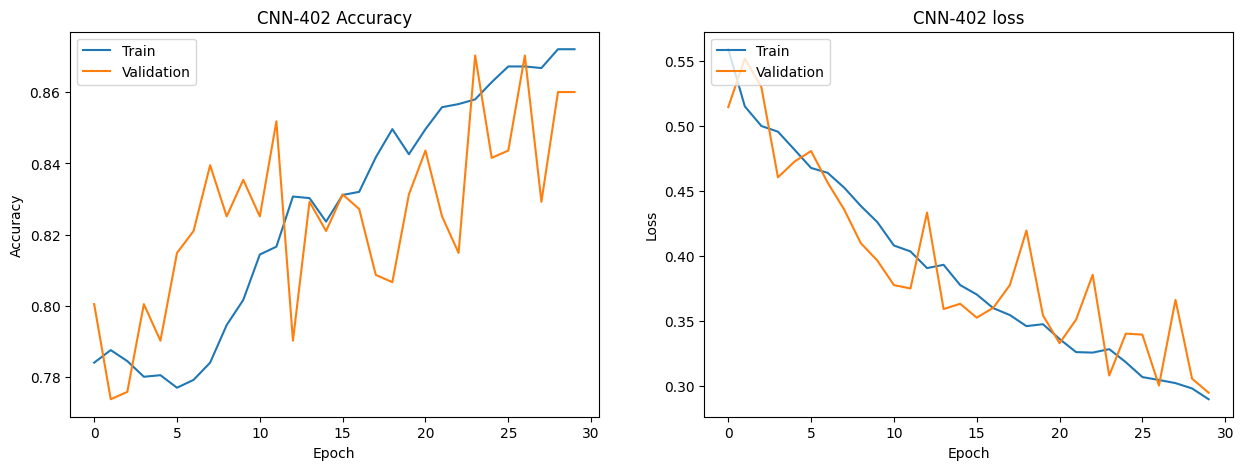

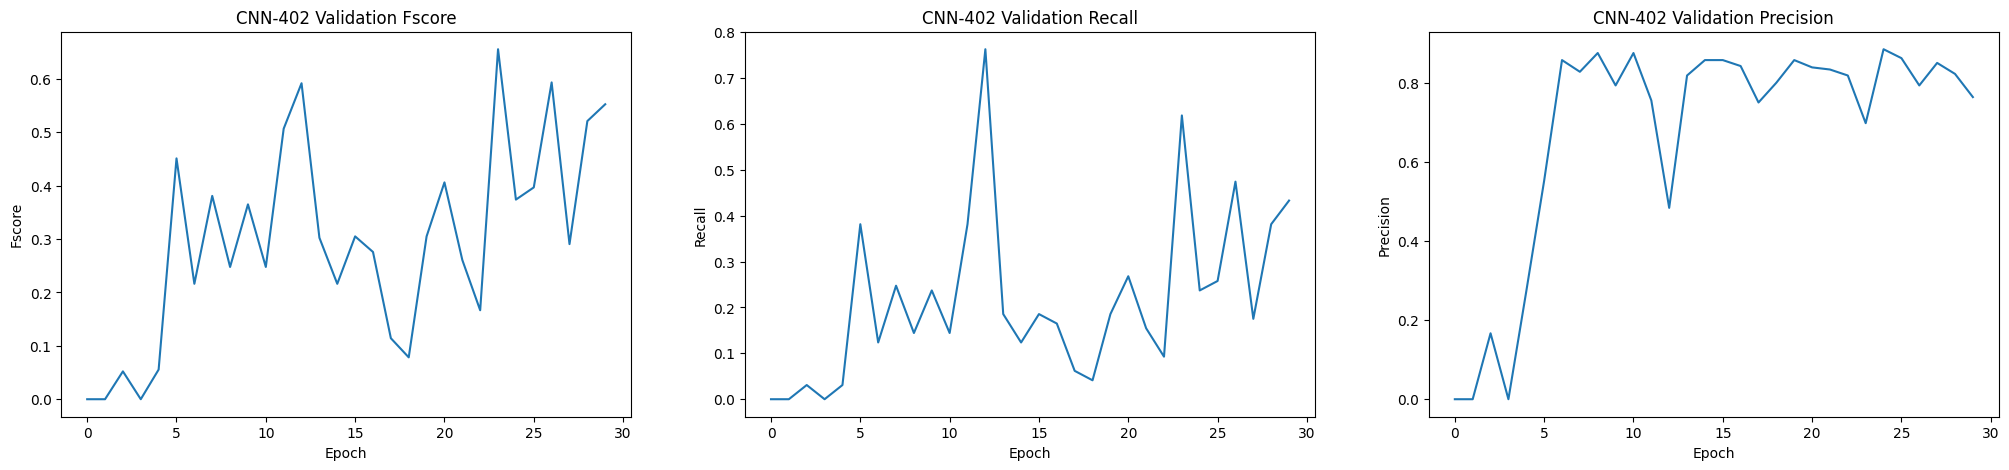

In [ ]:
# AlexNet
model402 = Sequential([
    Conv2D(16, kernel_size=2, activation='relu', input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(32, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(64, kernel_size=2, activation='relu'),
    Conv2D(128, kernel_size=2, activation='relu'),
    Conv2D(256, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

# compile
model402.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
model402.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = model402.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(model402.predict(xtest402),axis=1)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 39, 215, 16)       80        
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 19, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 19, 107, 16)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 18, 106, 32)       2080      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 9, 53, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 9, 53, 32)        

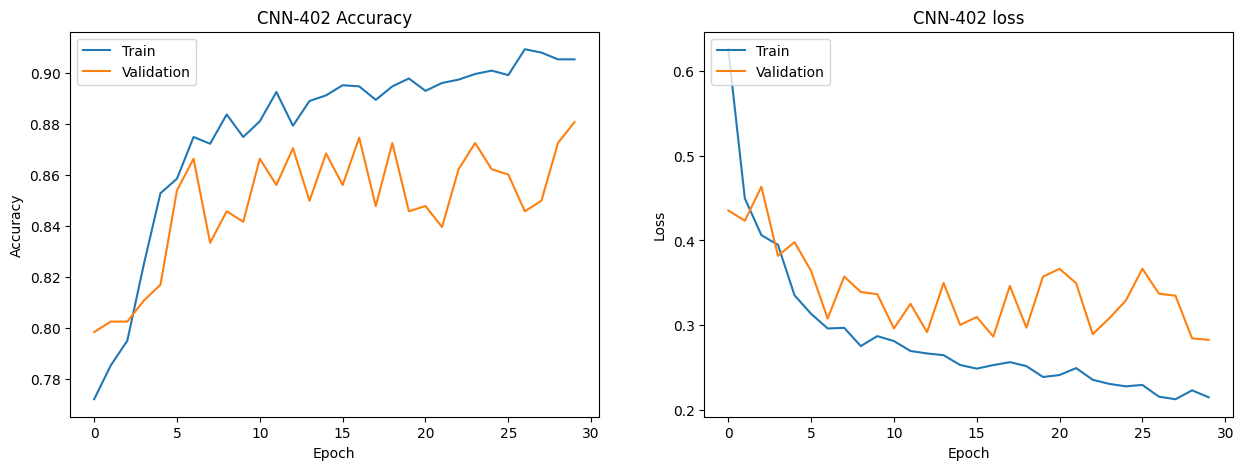

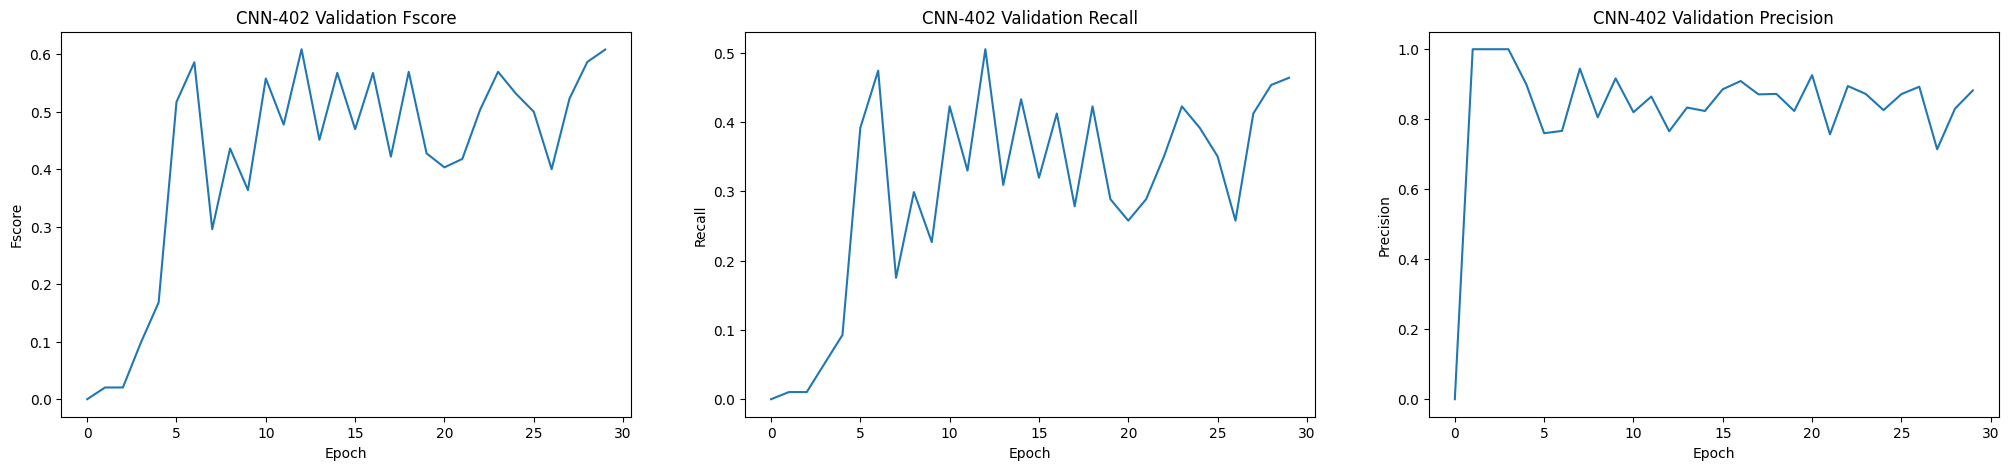

In [ ]:
# AlexNet
model402 = Sequential([
    Conv2D(16, kernel_size=2, activation='relu', input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(32, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(64, kernel_size=2, activation='relu'),
    Conv2D(128, kernel_size=2, activation='relu'),
    Conv2D(256, kernel_size=2, activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

# compile
model402.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model402.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = model402.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(model402.predict(xtest402),axis=1)))

# Final Model

### Adam optimizer - with dropouts

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_189 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_189 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_126 (Conv2D)         (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_190 (Ba  (None, 5, 27, 256)     

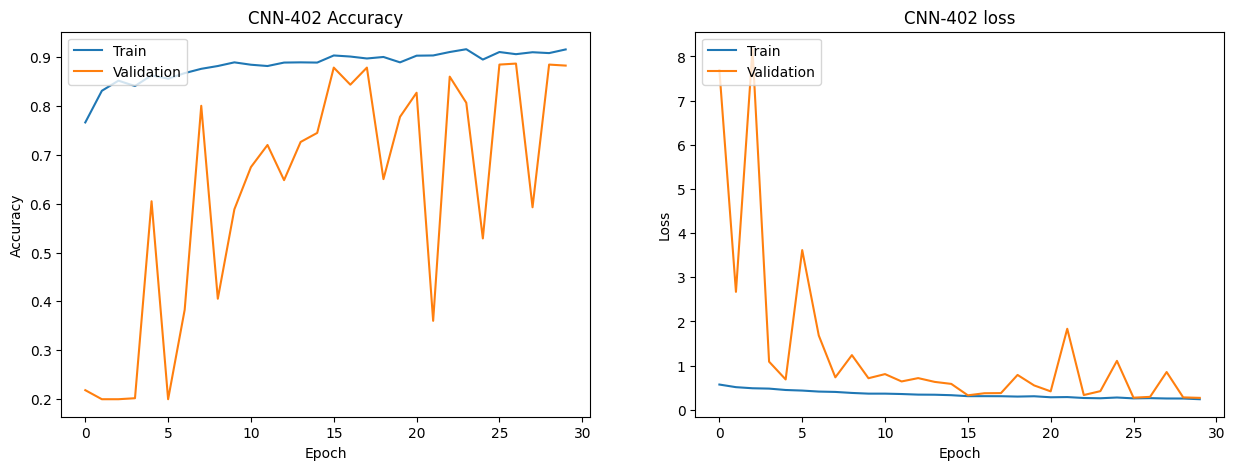

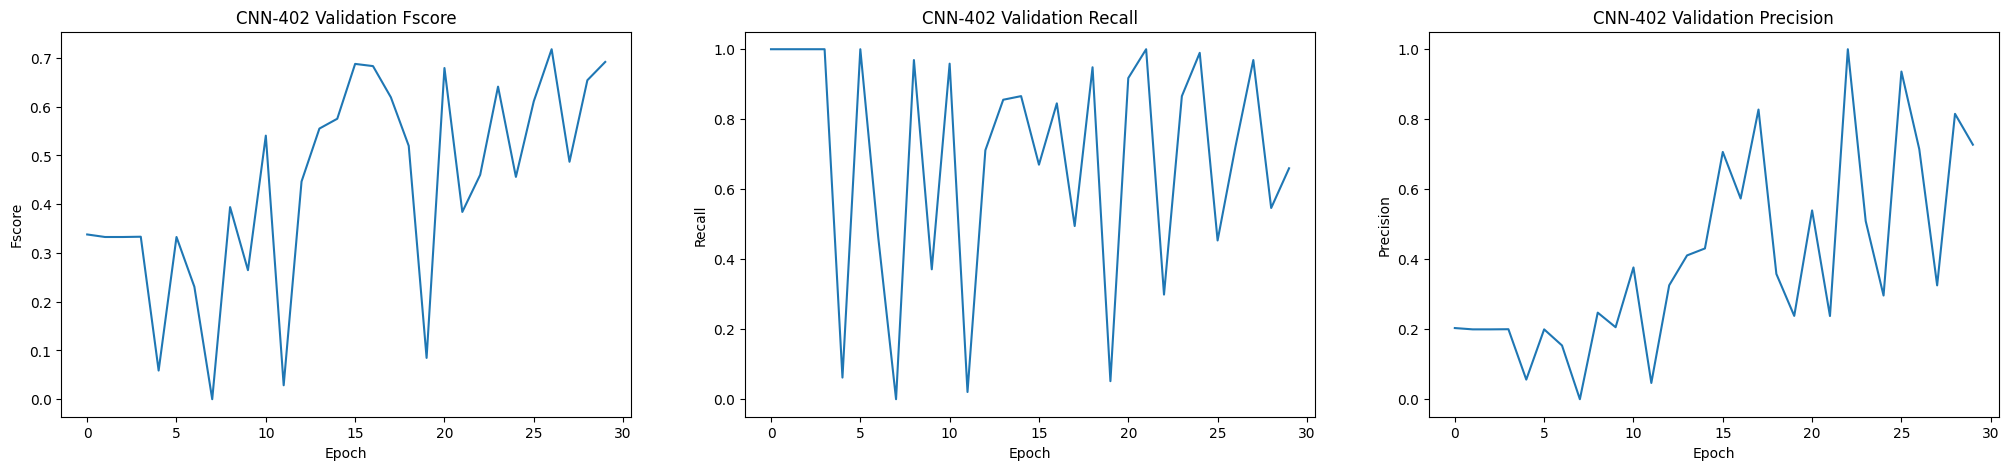

In [ ]:
MurmurNet = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Passing it to a fully connected layer
    Flatten(),

    # First Fully Connected Layer
    Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    BatchNormalization(),
    Activation('relu'),

    # Add Dropout to prevent overfitting
    Dropout(0.4),

    # Second Fully Connected Layer
    Dense(4096),
    BatchNormalization(),
    Activation('relu'),
    #Add Dropout
    Dropout(0.4),

    # Third Fully Connected Layer
    Dense(1000),
    BatchNormalization(),
    Activation('relu'),
    # Add Dropout
    Dropout(0.4),

    #Output Layer
    Dense(2),
    BatchNormalization(),
    Activation('softmax')
])

#Model Summary
MurmurNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

### Adam optimizer - without dropouts

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_108 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_108 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_109 (Ba  (None, 5, 27, 256)     

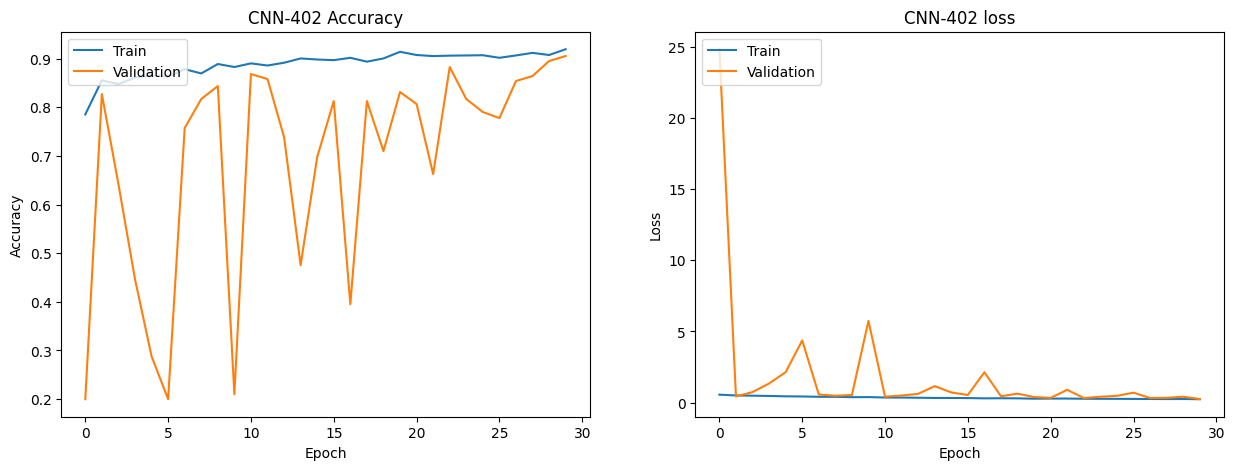

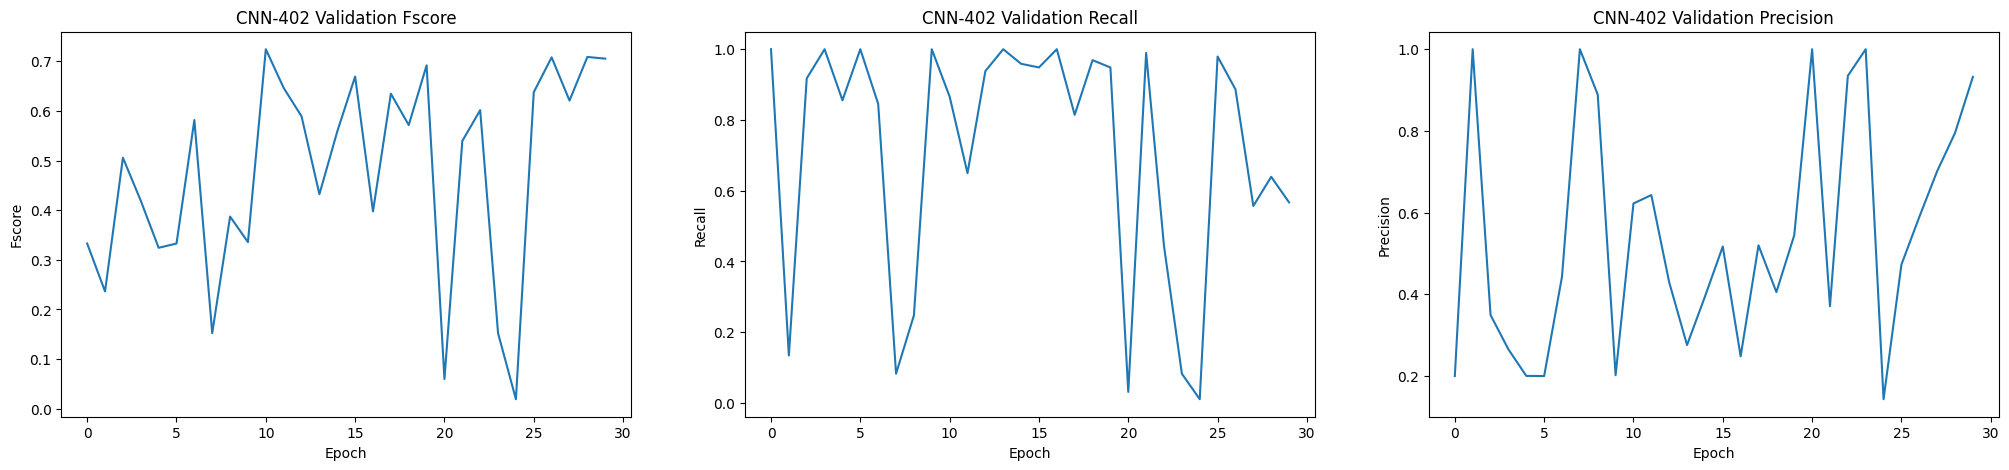

In [ ]:
MurmurNet = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Passing it to a fully connected layer
    Flatten(),

    # First Fully Connected Layer
    Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    BatchNormalization(),
    Activation('relu'),

    # Second Fully Connected Layer
    Dense(4096),
    BatchNormalization(),
    Activation('relu'),

    # Third Fully Connected Layer
    Dense(1000),
    BatchNormalization(),
    Activation('relu'),

    #Output Layer
    Dense(2),
    BatchNormalization(),
    Activation('softmax')
])

#Model Summary
MurmurNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

### SGD Optimizer - with dropouts

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_99 (Bat  (None, 10, 54, 96)       384       
 chNormalization)                                                
                                                                 
 activation_99 (Activation)  (None, 10, 54, 96)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_100 (Ba  (None, 5, 27, 256)     

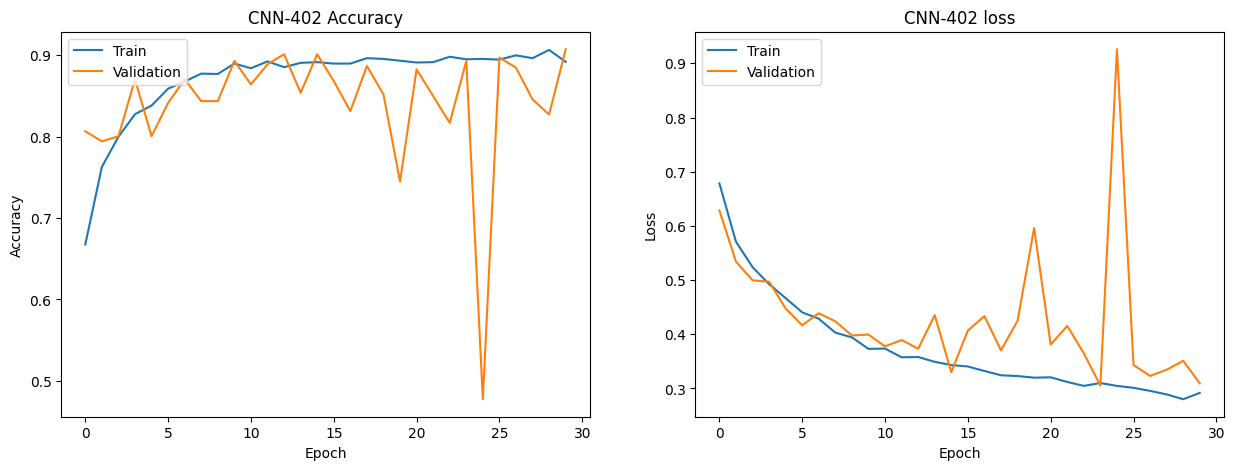

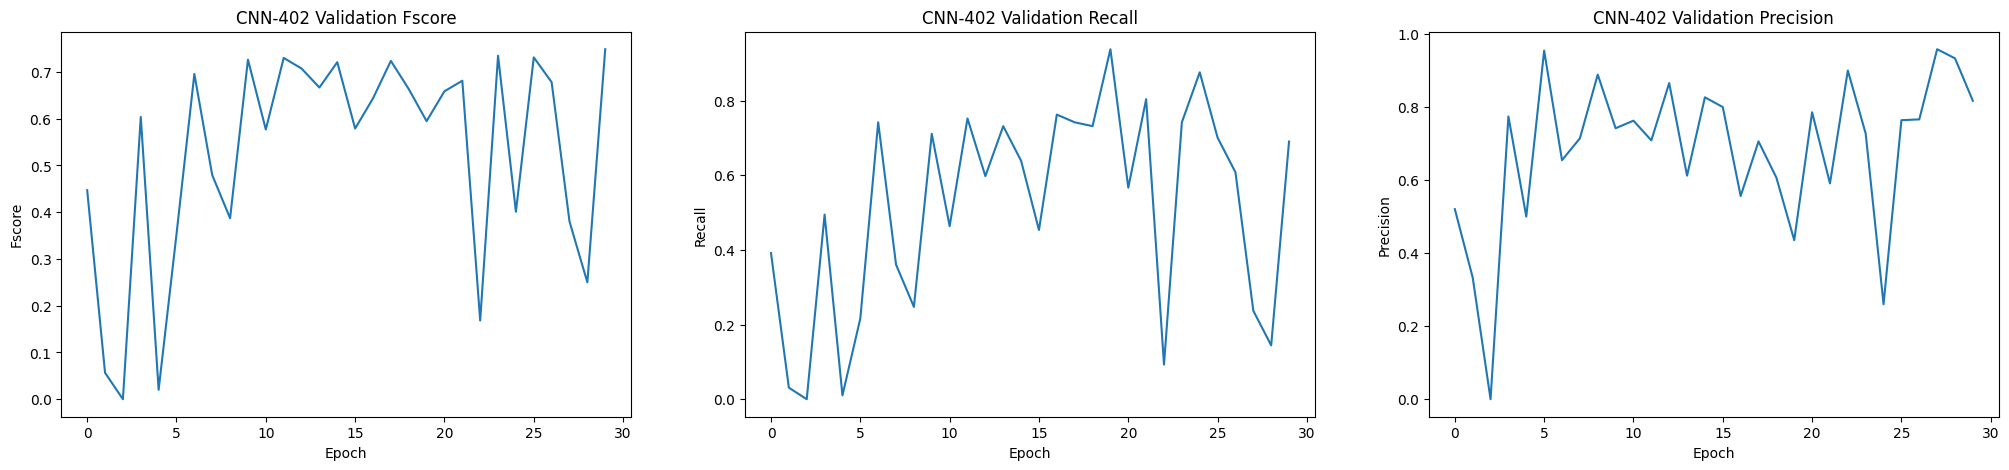

In [ ]:
MurmurNet = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Passing it to a fully connected layer
    Flatten(),

    # First Fully Connected Layer
    Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    BatchNormalization(),
    Activation('relu'),

    # Add Dropout to prevent overfitting
    Dropout(0.4),

    # Second Fully Connected Layer
    Dense(4096),
    BatchNormalization(),
    Activation('relu'),
    # Add Dropout
    Dropout(0.4),

    # Third Fully Connected Layer
    Dense(1000),
    BatchNormalization(),
    Activation('relu'),
    # Add Dropout
    Dropout(0.4),

    #Output Layer
    Dense(2),
    BatchNormalization(),
    Activation('softmax')
])

#Model Summary
MurmurNet.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

### SGD optimizer - without dropouts

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_63 (Bat  (None, 10, 54, 96)       384       
 chNormalization)                                                
                                                                 
 activation_63 (Activation)  (None, 10, 54, 96)        0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_64 (Bat  (None, 5, 27, 256)     

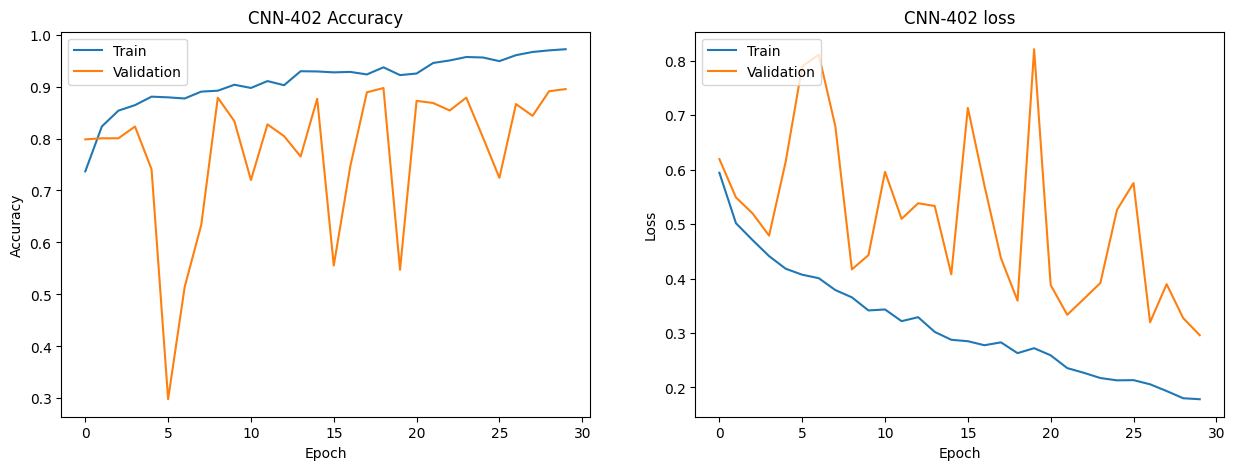

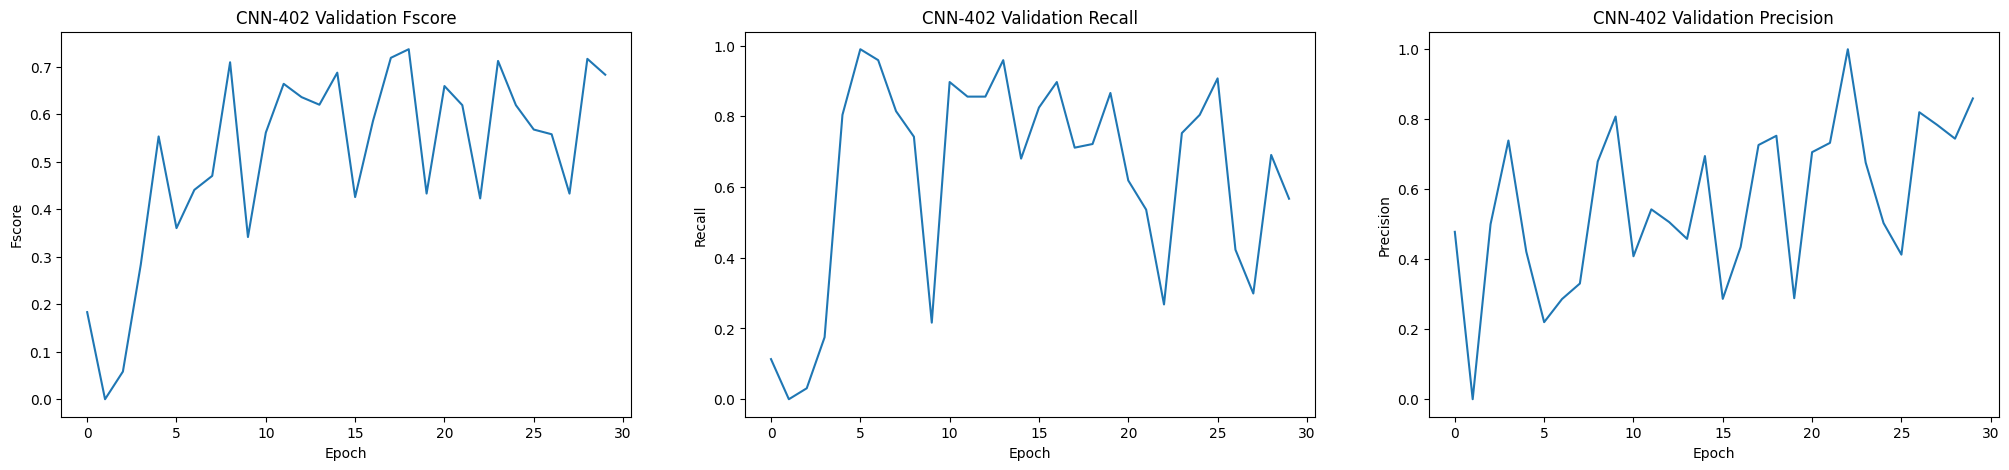

In [ ]:
MurmurNet = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

    # Passing it to a fully connected layer
    Flatten(),

    # First Fully Connected Layer
    Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)),
    BatchNormalization(),
    Activation('relu'),

    # Second Fully Connected Layer
    Dense(4096),
    BatchNormalization(),
    Activation('relu'),

    # Third Fully Connected Layer
    Dense(1000),
    BatchNormalization(),
    Activation('relu'),

    #Output Layer
    Dense(2),
    BatchNormalization(),
    Activation('softmax')
])

#Model Summary
MurmurNet.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

# Nadam Optimizer

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_126 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_126 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_127 (Ba  (None, 5, 27, 256)     

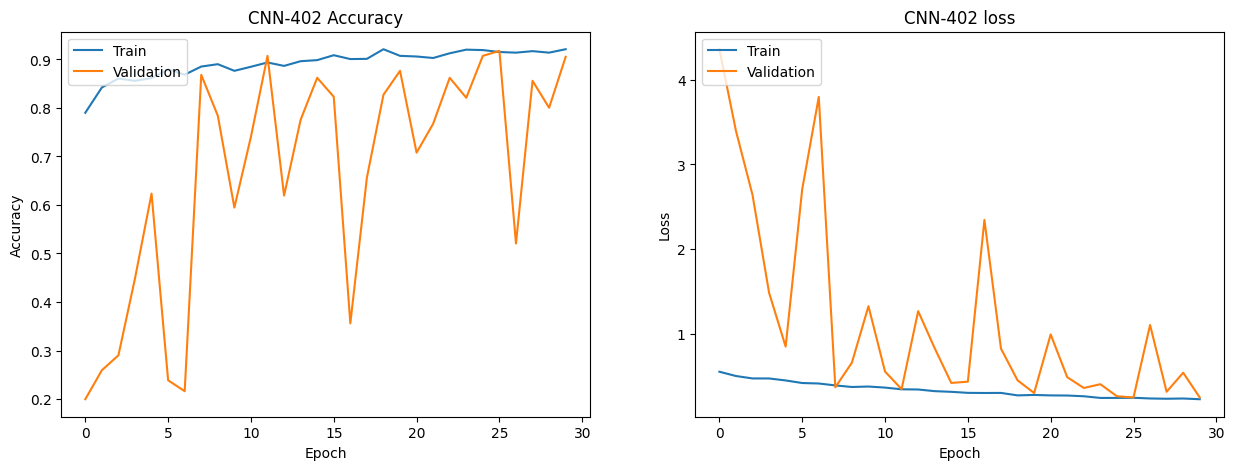

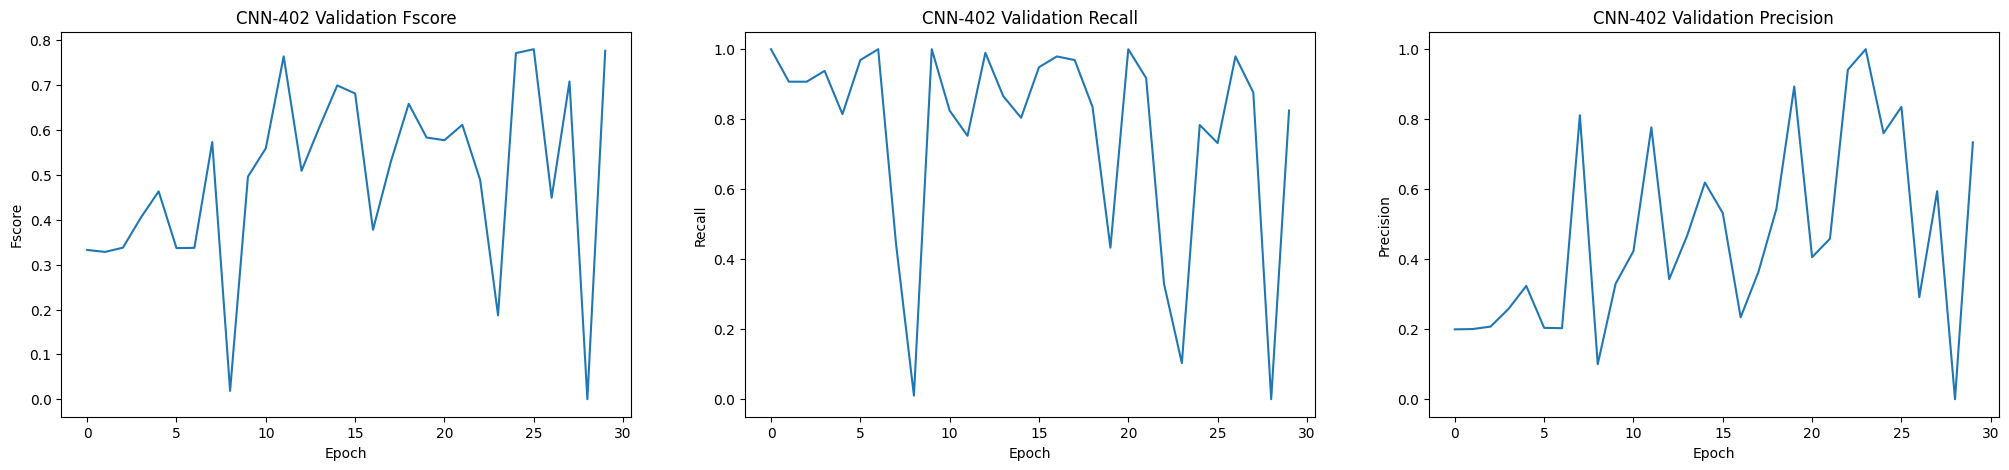

In [ ]:
MurmurNet = Sequential()

#1st Convolutional Layer
MurmurNet.add(Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#4th Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#5th Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
MurmurNet.add(Flatten())

# 1st Fully Connected Layer
MurmurNet.add(Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#2nd Fully Connected Layer
MurmurNet.add(Dense(4096))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#3rd Fully Connected Layer
MurmurNet.add(Dense(1000))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#Output Layer
MurmurNet.add(Dense(2))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('softmax'))

#Model Summary
MurmurNet.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

# Adagrad Optimizer

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_135 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_135 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_136 (Ba  (None, 5, 27, 256)     

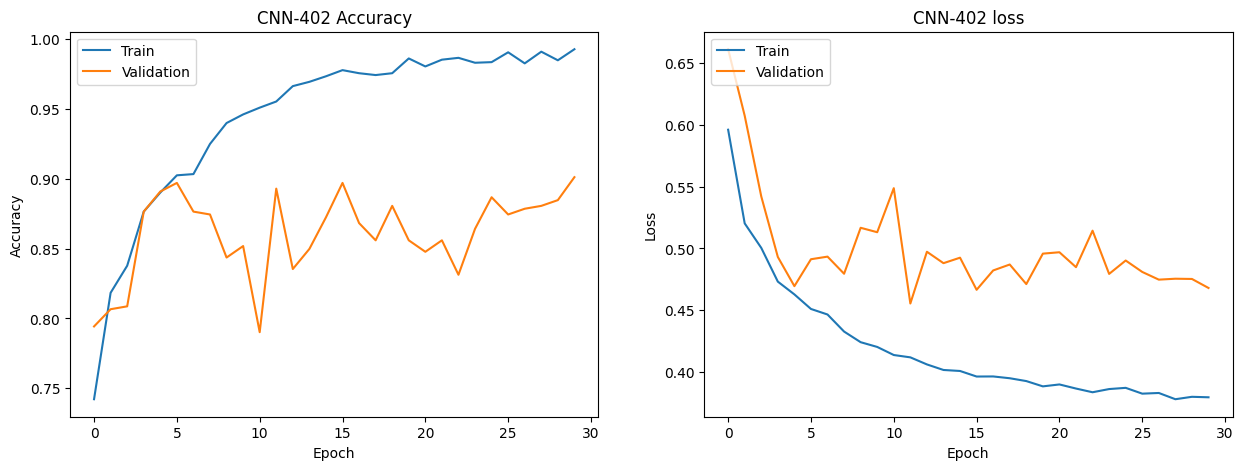

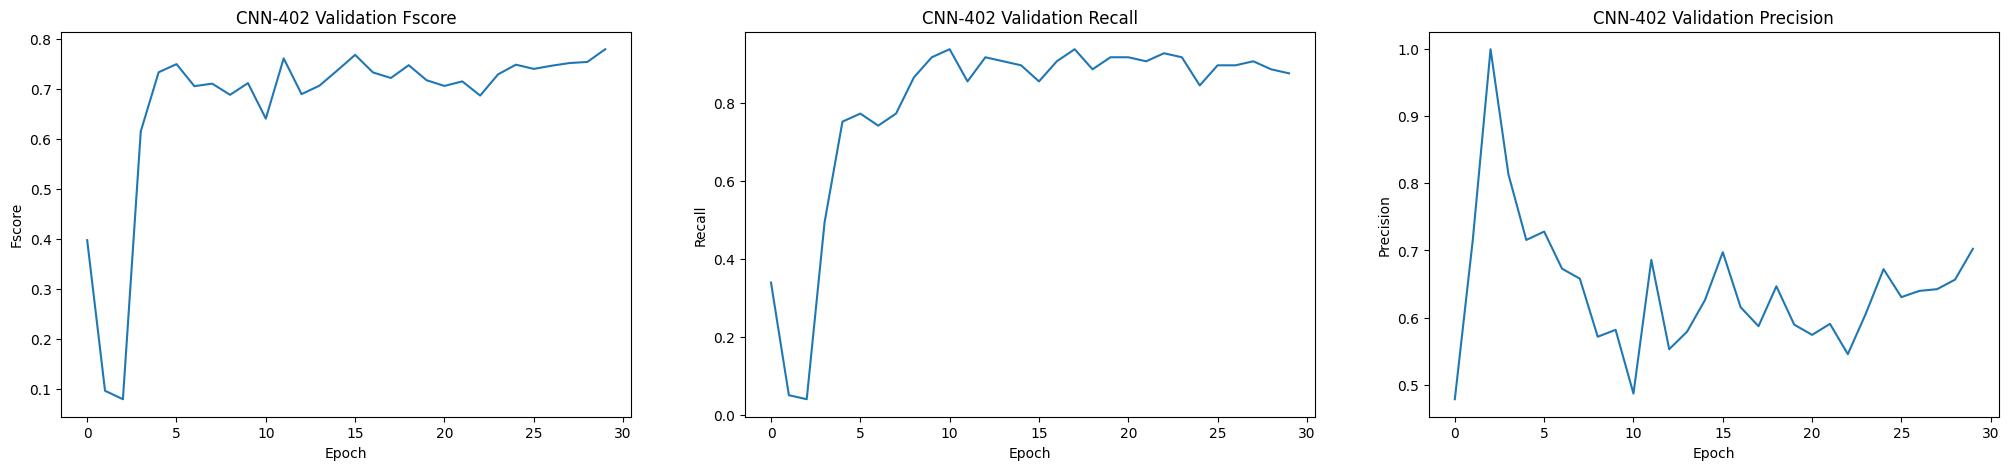

In [ ]:
MurmurNet = Sequential()

#1st Convolutional Layer
MurmurNet.add(Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#4th Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#5th Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
MurmurNet.add(Flatten())
# 1st Fully Connected Layer
MurmurNet.add(Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
# MurmurNet.add(Dropout(0.4))

#2nd Fully Connected Layer
MurmurNet.add(Dense(4096))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
#Add Dropout
# MurmurNet.add(Dropout(0.4))

#3rd Fully Connected Layer
MurmurNet.add(Dense(1000))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
#Add Dropout
# MurmurNet.add(Dropout(0.4))

#Output Layer
MurmurNet.add(Dense(2))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('softmax'))

#Model Summary
MurmurNet.compile(optimizer='adagrad',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

# RMSProp Optimizer

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_153 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_153 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_154 (Ba  (None, 5, 27, 256)     

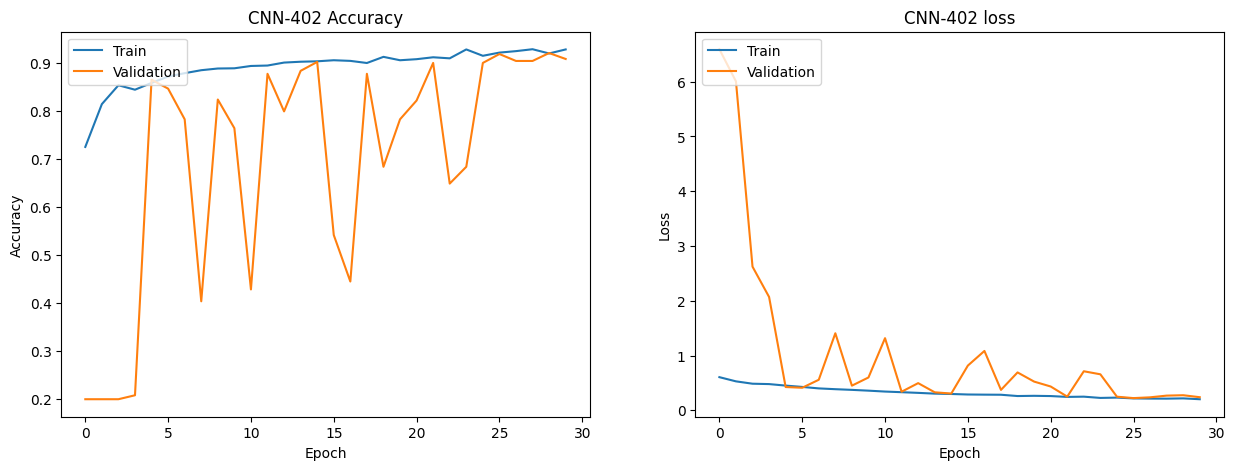

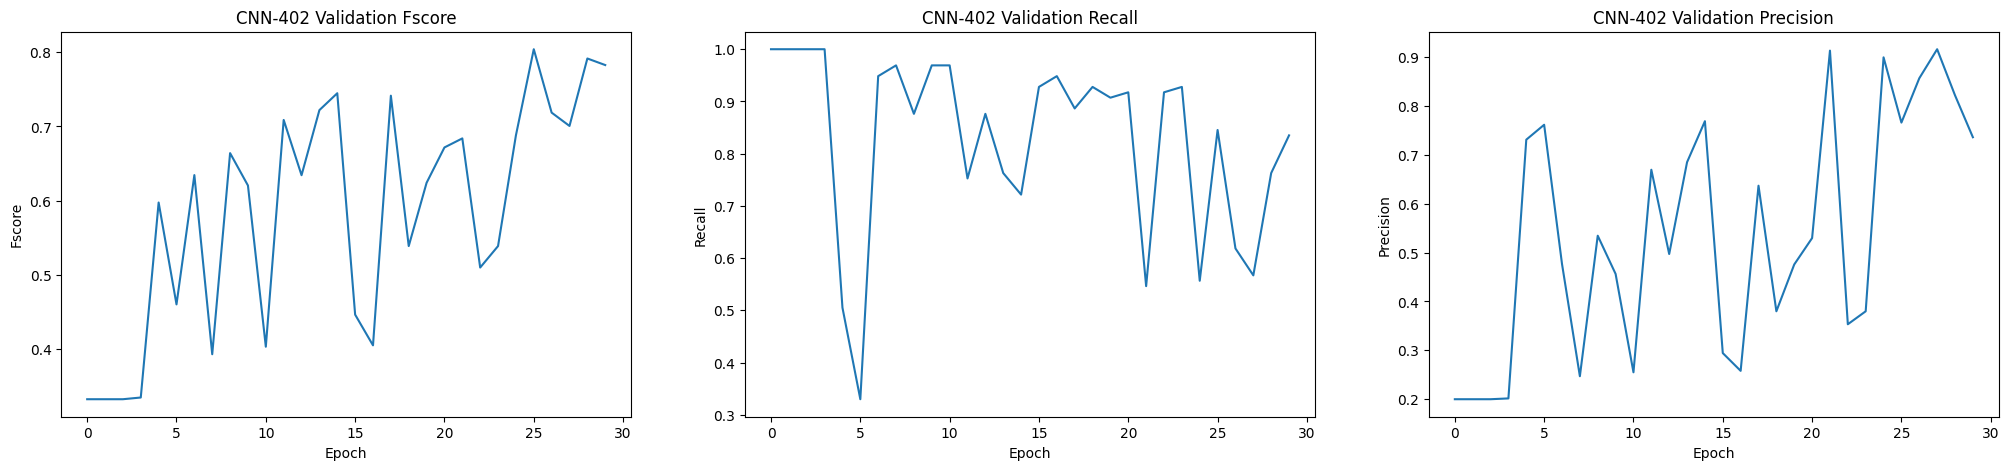

In [ ]:
MurmurNet = Sequential()

#1st Convolutional Layer
MurmurNet.add(Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#4th Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#5th Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
MurmurNet.add(Flatten())

# 1st Fully Connected Layer
MurmurNet.add(Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#2nd Fully Connected Layer
MurmurNet.add(Dense(4096))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#3rd Fully Connected Layer
MurmurNet.add(Dense(1000))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#Output Layer
MurmurNet.add(Dense(2))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('softmax'))

#Model Summary
MurmurNet.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

# Experimenting With Loss Functions

# Using only the best performing optimizers

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 10, 54, 96)        11712     
                                                                 
 batch_normalization_180 (Ba  (None, 10, 54, 96)       384       
 tchNormalization)                                               
                                                                 
 activation_180 (Activation)  (None, 10, 54, 96)       0         
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 5, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 5, 27, 256)        98560     
                                                                 
 batch_normalization_181 (Ba  (None, 5, 27, 256)     

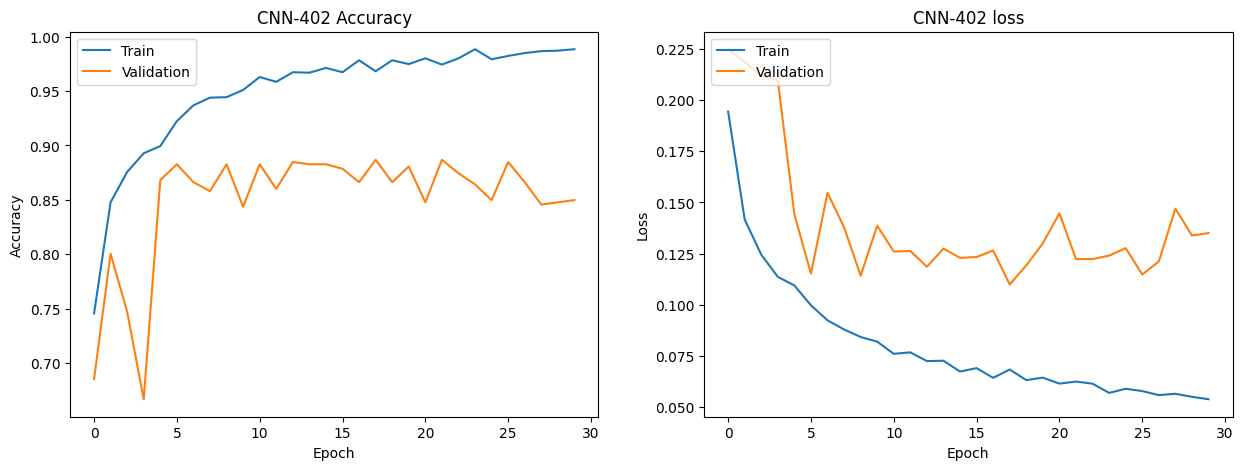

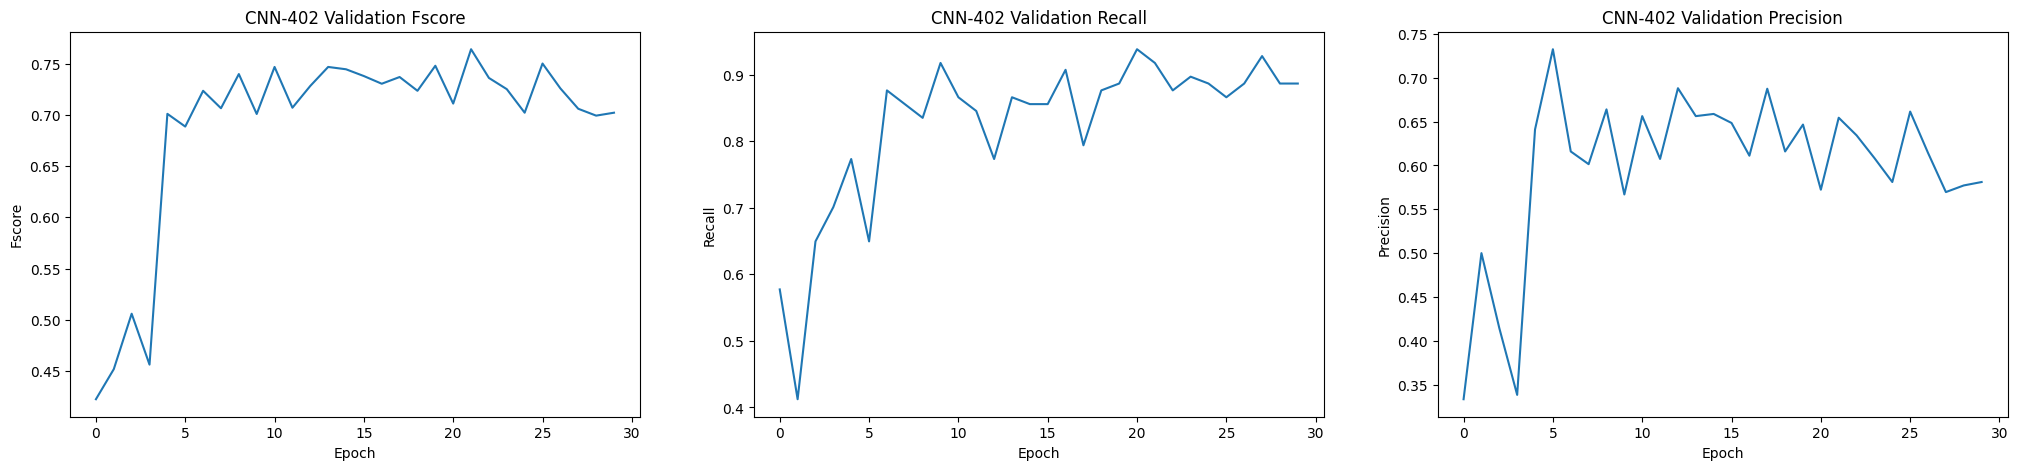

In [ ]:
MurmurNet = Sequential()

#1st Convolutional Layer
MurmurNet.add(Conv2D(filters=96, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1), kernel_size=(11,11), strides=(4,4), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=2, strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#4th Convolutional Layer
MurmurNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#5th Convolutional Layer
MurmurNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))
MurmurNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
MurmurNet.add(Flatten())
# 1st Fully Connected Layer
MurmurNet.add(Dense(4096, input_shape=(xtrain402.shape[1],xtrain402.shape[2],1)))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#2nd Fully Connected Layer
MurmurNet.add(Dense(4096))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#3rd Fully Connected Layer
MurmurNet.add(Dense(1000))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('relu'))

#Output Layer
MurmurNet.add(Dense(2))
MurmurNet.add(BatchNormalization())
MurmurNet.add(Activation('softmax'))

#Model Summary
MurmurNet.compile(optimizer='adagrad',loss='mean_squared_error',metrics=['accuracy'])
MurmurNet.summary()

# train model
metrics402 = Metrics(validation_data=(xvalid402, yvalid402))
history402 = MurmurNet.fit(xtrain402, ytrain402, validation_data=(xvalid402, yvalid402),
                        epochs=30, callbacks=[metrics402], verbose=2)

plot_history(history402, 'CNN-402')
plot_metrics(metrics402, 'CNN-402')

print(classification_report(np.argmax(ytest402,axis=1), np.argmax(MurmurNet.predict(xtest402),axis=1)))

In [ ]:
MurmurNet.save("model.h5")